In [127]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import itertools

In [128]:
# Desired resolution (modify as needed)
desired_res = (64, 64, 64)
desired_res = (32, 32, 32)

hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
num_epochs = 100
print_every = 1
# in_channels, out_channels, kernel_size, stride, padding
stages = [
    [(1, 32, 3, 1, 1), (32, 32, 3, 1, 1), (32, 32, 3, 1, 1)],
    # [(32, 64, 5, 1, 1), (64, 64, 5, 1, 1), (64, 64, 5, 1, 1)]
]
stages = [
       [(1, 16, 3, 1, 1), (16, 16, 3, 1, 1)],  # Fewer channels
    [(16, 32, 5, 1, 1), (32, 32, 5, 1, 1)]
]

# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding
pooling_configs = [
    (2, 2, 1),  # Pooling after the first stage
    # (2, 2, 1)      # No pooling after the third stage
]

In [129]:
import os
print(os.listdir('../'))

['DATA', 'best_models', '4foils_L270_0.15_50_64x64x64_v1', '4foils_L270_0.25_50_64x64x64_v1', 'HOPFS_L270_0.05_1000_64x64x64_v1', 'my_functions', '4foils_L270_0.05_50_64x64x64_v1', '4foils_L270_0.05_450_64x64x64_v1', 'ML_ipynb', 'fix_names_folders.py', 'HOPFS_L270_0.25_1000_64x64x64_v1', '4foils_L270_0.15_450_64x64x64_v1', 'classification_spectrum_tunning', 'HOPFS_L270_0.15_1000_64x64x64_v1', 'classification_knots_tunning', 'HOPFS_L270_0.15_20_64x64x64_v1', 'functions', 'data_generation']


In [130]:

foils = list(itertools.product(range(3), repeat=4))
foils = foils[:]
knots = [''.join([str(element) for element in foil]) for foil in foils]
knot_types = {
    knot : it for it, knot in enumerate(knots)
}

# folder = '../DATA/HOPFS_L270_5e-07_test_1s'
# folder = '../HOPFS_L270_5e-07_test_1s'
# List of folders to search for data
folders = [
    '../4foils_L270_0.15_50_64x64x64_v1',
    '../4foils_L270_0.05_50_64x64x64_v1',
    '../4foils_L270_0.25_50_64x64x64_v1'
]
# folders = [
#     '../HOPFS_L270_0.05_1_64x64x64_v1',
#     '../HOPFS_L270_5e-07_test_1s',
# ]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True


# Loop through all folders and knots
for folder in folders:
    for knot in knots:
        filename = f'{folder}/data_{knot}.csv'
        try:
            with open(filename, 'r') as file:
                reader = csv.reader(file)
                for row in reader:
                    # Deserialize the JSON string back to a list
                    data_list = json.loads(row[0])
                    data_array = np.array(data_list)

                    # Extract points and dimensions
                    points_list = data_array[2:]
                    Nx, Ny, Nz = data_array[1]

                    if flag_print_shape:
                        print(f'Shape: {Nx}, {Ny}, {Nz}')
                        flag_print_shape = False

                    # Rescale if necessary
                    if desired_res != (Nx, Ny, Nz):
                        scale_x = desired_res[0] / Nx
                        scale_y = desired_res[1] / Ny
                        scale_z = desired_res[2] / Nz
                        points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

                    # Initialize a 3D array and set points to 1
                    dots_3d = np.zeros(desired_res, dtype=int)
                    for x, y, z in points_list:
                        try:
                            dots_3d[x, y, z] = 1
                        except IndexError:
                            continue

                    # Append to lists
                    X_list.append(dots_3d)
                    Y_list.append(knot_types[knot])

        except FileNotFoundError:
            print(f'File not found: {filename}')
        except json.JSONDecodeError:
            print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

Shape: 64, 64, 64
Loaded 12150 samples.  150 per class


In [131]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
# print(X_np)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)

torch.Size([12150, 1, 32, 32, 32]) torch.Size([12150, 81])


In [132]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [133]:
def conv_stage(layer_configs):
    layers = []
    for config in layer_configs:
        in_channels, out_channels, kernel_size, stride, padding = config
        layers.append(nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm3d(out_channels))
        layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)

def create_pooling_layer(config):
    if config is None:
        return None
    kernel_size, stride, padding = config
    return nn.MaxPool3d(kernel_size=kernel_size, stride=stride, padding=padding)

class Classifier3D(nn.Module):
    def __init__(self, stages, pooling_configs, num_classes=11):
        super(Classifier3D, self).__init__()

        self.features = nn.Sequential()
        self.desired = desired_res

        for i, stage in enumerate(stages):
            # Add the convolutional stage
            self.features.add_module(f"stage_{i}", conv_stage(stage))

            # Add a custom MaxPooling layer after each stage based on the pooling configuration
            if i < len(pooling_configs):
                pool_layer = create_pooling_layer(pooling_configs[i])
                if pool_layer:
                    self.features.add_module(f"pool_{i}", pool_layer)


        # Calculate the size of the flattened features after the conv layers
        self._to_linear = None
        self._get_conv_output((1, *self.desired))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        # self.fc2 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        self._to_linear = int(np.prod(output_feat.size()[1:]))

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x


In [134]:


model = Classifier3D(stages, pooling_configs, num_classes=len(knots)).to(device)
model.initialize_weights()

In [135]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:2][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch))
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([1, 1, 32, 32, 32])
tensor([[-0.1070,  0.1877,  0.0270, -0.2977,  0.1273,  0.1170, -0.4131, -0.0430,
         -0.0072, -0.1784,  0.1812, -0.1414, -0.1206,  0.2776, -0.0695,  0.3032,
          0.0899,  0.2844, -0.1630,  0.0695, -0.2051,  0.0713,  0.1115,  0.0285,
         -0.1203,  0.1826,  0.0611,  0.1197, -0.3273,  0.1178,  0.0492,  0.1087,
          0.3274, -0.0945, -0.2229, -0.1337,  0.1452,  0.1341, -0.2244, -0.1566,
          0.1823,  0.0491, -0.0872,  0.0232, -0.2711, -0.1244, -0.2246, -0.0678,
         -0.2011, -0.3049, -0.2758, -0.0534, -0.3362,  0.1793,  0.1323,  0.0927,
         -0.2850, -0.0903,  0.5197,  0.0743,  0.0131,  0.1670,  0.0777,  0.2719,
          0.1175, -0.0621, -0.3402, -0.0178,  0.0808, -0.2355, -0.4653,  0.1895,
         -0.2954, -0.1571, -0.0452, -0.2714,  0.2800, -0.0425, -0.2161,  0.2351,
          0.4217]], device='cuda:0', grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)           

In [136]:
from torch.cuda.amp import autocast, GradScaler

# Initialize the GradScaler for mixed precision
scaler = GradScaler()

def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
         # Use autocast for mixed precision
        with autocast():
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
        
        # Scale the loss for numerical stability during backward pass
        scaler.scale(loss).backward()  # Backward pass
        
        # Step the optimizer using the scaled gradients
        scaler.step(optimizer)
        scaler.update()  # Update the scaler for next iteration

        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [137]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)


train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')


Progress:   1%|▋                                                                        | 1/100 [00:05<08:52,  5.38s/it]

Epoch 0 completed in 5.38 seconds
Epoch 0: Train Loss: 4.2836, Val Loss: 4.1237


Progress:   2%|█▍                                                                       | 2/100 [00:10<08:39,  5.30s/it]

Epoch 1 completed in 5.24 seconds
Epoch 1: Train Loss: 3.8180, Val Loss: 3.6074


Progress:   3%|██▏                                                                      | 3/100 [00:15<08:31,  5.27s/it]

Epoch 2 completed in 5.24 seconds
Epoch 2: Train Loss: 3.2053, Val Loss: 3.0518


Progress:   4%|██▉                                                                      | 4/100 [00:21<08:26,  5.27s/it]

Epoch 3 completed in 5.27 seconds
Epoch 3: Train Loss: 2.6621, Val Loss: 2.6334


Progress:   5%|███▋                                                                     | 5/100 [00:26<08:20,  5.27s/it]

Epoch 4 completed in 5.28 seconds
Epoch 4: Train Loss: 2.2697, Val Loss: 2.3605


Progress:   6%|████▍                                                                    | 6/100 [00:31<08:16,  5.28s/it]

Epoch 5 completed in 5.30 seconds
Epoch 5: Train Loss: 1.9897, Val Loss: 2.1650


Progress:   7%|█████                                                                    | 7/100 [00:37<08:12,  5.29s/it]

Epoch 6 completed in 5.31 seconds
Epoch 6: Train Loss: 1.7844, Val Loss: 2.0415


Progress:   8%|█████▊                                                                   | 8/100 [00:42<08:07,  5.30s/it]

Epoch 7 completed in 5.32 seconds
Epoch 7: Train Loss: 1.6222, Val Loss: 1.9455


Progress:   9%|██████▌                                                                  | 9/100 [00:47<08:03,  5.31s/it]

Epoch 8 completed in 5.33 seconds
Epoch 8: Train Loss: 1.4932, Val Loss: 1.8601


Progress:  10%|███████▏                                                                | 10/100 [00:53<07:59,  5.32s/it]

Epoch 9 completed in 5.35 seconds
Epoch 9: Train Loss: 1.3815, Val Loss: 1.8030


Progress:  11%|███████▉                                                                | 11/100 [00:58<07:54,  5.33s/it]

Epoch 10 completed in 5.35 seconds
Epoch 10: Train Loss: 1.2813, Val Loss: 1.7655


Progress:  12%|████████▋                                                               | 12/100 [01:03<07:50,  5.34s/it]

Epoch 11 completed in 5.37 seconds
Epoch 11: Train Loss: 1.1979, Val Loss: 1.7204


Progress:  13%|█████████▎                                                              | 13/100 [01:09<07:45,  5.35s/it]

Epoch 12 completed in 5.37 seconds
Epoch 12: Train Loss: 1.1216, Val Loss: 1.6850


Progress:  14%|██████████                                                              | 14/100 [01:14<07:41,  5.36s/it]

Epoch 13 completed in 5.38 seconds
Epoch 13: Train Loss: 1.0486, Val Loss: 1.6643


Progress:  15%|██████████▊                                                             | 15/100 [01:19<07:36,  5.37s/it]

Epoch 14 completed in 5.39 seconds
Epoch 14: Train Loss: 0.9831, Val Loss: 1.6415


Progress:  16%|███████████▌                                                            | 16/100 [01:25<07:31,  5.38s/it]

Epoch 15 completed in 5.40 seconds
Epoch 15: Train Loss: 0.9195, Val Loss: 1.6212


Progress:  17%|████████████▏                                                           | 17/100 [01:30<07:27,  5.39s/it]

Epoch 16 completed in 5.41 seconds
Epoch 16: Train Loss: 0.8659, Val Loss: 1.6086


Progress:  18%|████████████▉                                                           | 18/100 [01:36<07:22,  5.40s/it]

Epoch 17 completed in 5.41 seconds
Epoch 17: Train Loss: 0.8099, Val Loss: 1.5961


Progress:  19%|█████████████▋                                                          | 19/100 [01:41<07:17,  5.40s/it]

Epoch 18 completed in 5.41 seconds
Epoch 18: Train Loss: 0.7566, Val Loss: 1.5801


Progress:  20%|██████████████▍                                                         | 20/100 [01:46<07:12,  5.40s/it]

Epoch 19 completed in 5.41 seconds
Epoch 19: Train Loss: 0.7096, Val Loss: 1.5699


Progress:  21%|███████████████                                                         | 21/100 [01:52<07:06,  5.40s/it]

Epoch 20 completed in 5.41 seconds
Epoch 20: Train Loss: 0.6625, Val Loss: 1.5550


Progress:  22%|███████████████▊                                                        | 22/100 [01:57<07:01,  5.41s/it]

Epoch 21 completed in 5.41 seconds
Epoch 21: Train Loss: 0.6170, Val Loss: 1.5575


Progress:  23%|████████████████▌                                                       | 23/100 [02:03<06:56,  5.41s/it]

Epoch 22 completed in 5.42 seconds
Epoch 22: Train Loss: 0.5754, Val Loss: 1.5440


Progress:  24%|█████████████████▎                                                      | 24/100 [02:08<06:52,  5.43s/it]

Epoch 23 completed in 5.47 seconds
Epoch 23: Train Loss: 0.5352, Val Loss: 1.5413


Progress:  25%|██████████████████                                                      | 25/100 [02:14<06:47,  5.43s/it]

Epoch 24 completed in 5.43 seconds
Epoch 24: Train Loss: 0.4974, Val Loss: 1.5340


Progress:  26%|██████████████████▋                                                     | 26/100 [02:19<06:41,  5.43s/it]

Epoch 25 completed in 5.43 seconds
Epoch 25: Train Loss: 0.4623, Val Loss: 1.5310


Progress:  27%|███████████████████▍                                                    | 27/100 [02:24<06:36,  5.43s/it]

Epoch 26 completed in 5.43 seconds
Epoch 26: Train Loss: 0.4288, Val Loss: 1.5190


Progress:  28%|████████████████████▏                                                   | 28/100 [02:30<06:31,  5.43s/it]

Epoch 27 completed in 5.43 seconds
Epoch 27: Train Loss: 0.3983, Val Loss: 1.5141


Progress:  29%|████████████████████▉                                                   | 29/100 [02:35<06:25,  5.43s/it]

Epoch 28 completed in 5.44 seconds
Epoch 28: Train Loss: 0.3671, Val Loss: 1.5147


Progress:  30%|█████████████████████▌                                                  | 30/100 [02:41<06:20,  5.44s/it]

Epoch 29 completed in 5.45 seconds
Epoch 29: Train Loss: 0.3399, Val Loss: 1.5145


Progress:  31%|██████████████████████▎                                                 | 31/100 [02:46<06:15,  5.44s/it]

Epoch 30 completed in 5.45 seconds
Epoch 30: Train Loss: 0.3134, Val Loss: 1.5057


Progress:  32%|███████████████████████                                                 | 32/100 [02:52<06:10,  5.45s/it]

Epoch 31 completed in 5.46 seconds
Epoch 31: Train Loss: 0.2882, Val Loss: 1.5042


Progress:  33%|███████████████████████▊                                                | 33/100 [02:57<06:05,  5.45s/it]

Epoch 32 completed in 5.47 seconds
Epoch 32: Train Loss: 0.2658, Val Loss: 1.5061


Progress:  34%|████████████████████████▍                                               | 34/100 [03:03<05:59,  5.45s/it]

Epoch 33 completed in 5.45 seconds
Epoch 33: Train Loss: 0.2445, Val Loss: 1.5026


Progress:  35%|█████████████████████████▏                                              | 35/100 [03:08<05:54,  5.45s/it]

Epoch 34 completed in 5.44 seconds
Epoch 34: Train Loss: 0.2260, Val Loss: 1.5063


Progress:  36%|█████████████████████████▉                                              | 36/100 [03:13<05:48,  5.45s/it]

Epoch 35 completed in 5.44 seconds
Epoch 35: Train Loss: 0.2073, Val Loss: 1.5047


Progress:  37%|██████████████████████████▋                                             | 37/100 [03:19<05:43,  5.45s/it]

Epoch 36 completed in 5.44 seconds
Epoch 36: Train Loss: 0.1908, Val Loss: 1.4977


Progress:  38%|███████████████████████████▎                                            | 38/100 [03:24<05:37,  5.45s/it]

Epoch 37 completed in 5.45 seconds
Epoch 37: Train Loss: 0.1755, Val Loss: 1.4979


Progress:  39%|████████████████████████████                                            | 39/100 [03:30<05:32,  5.45s/it]

Epoch 38 completed in 5.45 seconds
Epoch 38: Train Loss: 0.1615, Val Loss: 1.4964


Progress:  40%|████████████████████████████▊                                           | 40/100 [03:35<05:27,  5.45s/it]

Epoch 39 completed in 5.46 seconds
Epoch 39: Train Loss: 0.1486, Val Loss: 1.5000


Progress:  41%|█████████████████████████████▌                                          | 41/100 [03:41<05:22,  5.46s/it]

Epoch 40 completed in 5.48 seconds
Epoch 40: Train Loss: 0.1366, Val Loss: 1.5046


Progress:  42%|██████████████████████████████▏                                         | 42/100 [03:46<05:16,  5.46s/it]

Epoch 41 completed in 5.47 seconds
Epoch 41: Train Loss: 0.1256, Val Loss: 1.5046


Progress:  43%|██████████████████████████████▉                                         | 43/100 [03:52<05:11,  5.47s/it]

Epoch 42 completed in 5.47 seconds
Epoch 42: Train Loss: 0.1152, Val Loss: 1.4985


Progress:  44%|███████████████████████████████▋                                        | 44/100 [03:57<05:06,  5.46s/it]

Epoch 43 completed in 5.46 seconds
Epoch 43: Train Loss: 0.1069, Val Loss: 1.5017


Progress:  45%|████████████████████████████████▍                                       | 45/100 [04:03<05:00,  5.46s/it]

Epoch 00045: reducing learning rate of group 0 to 2.0000e-06.
Epoch 44 completed in 5.46 seconds
Epoch 44: Train Loss: 0.0975, Val Loss: 1.5015


Progress:  46%|█████████████████████████████████                                       | 46/100 [04:08<04:54,  5.46s/it]

Epoch 45 completed in 5.46 seconds
Epoch 45: Train Loss: 0.0895, Val Loss: 1.4978


Progress:  47%|█████████████████████████████████▊                                      | 47/100 [04:14<04:49,  5.46s/it]

Epoch 46 completed in 5.46 seconds
Epoch 46: Train Loss: 0.0874, Val Loss: 1.4962


Progress:  48%|██████████████████████████████████▌                                     | 48/100 [04:19<04:43,  5.46s/it]

Epoch 47 completed in 5.46 seconds
Epoch 47: Train Loss: 0.0860, Val Loss: 1.4991


Progress:  49%|███████████████████████████████████▎                                    | 49/100 [04:24<04:38,  5.46s/it]

Epoch 48 completed in 5.45 seconds
Epoch 48: Train Loss: 0.0844, Val Loss: 1.4999


Progress:  50%|████████████████████████████████████                                    | 50/100 [04:30<04:32,  5.45s/it]

Epoch 49 completed in 5.44 seconds
Epoch 49: Train Loss: 0.0831, Val Loss: 1.5017


Progress:  51%|████████████████████████████████████▋                                   | 51/100 [04:35<04:27,  5.45s/it]

Epoch 50 completed in 5.45 seconds
Epoch 50: Train Loss: 0.0816, Val Loss: 1.5005


Progress:  52%|█████████████████████████████████████▍                                  | 52/100 [04:41<04:21,  5.45s/it]

Epoch 51 completed in 5.45 seconds
Epoch 51: Train Loss: 0.0800, Val Loss: 1.5025


Progress:  53%|██████████████████████████████████████▏                                 | 53/100 [04:46<04:16,  5.45s/it]

Epoch 00053: reducing learning rate of group 0 to 4.0000e-07.
Epoch 52 completed in 5.46 seconds
Epoch 52: Train Loss: 0.0785, Val Loss: 1.5014


Progress:  54%|██████████████████████████████████████▉                                 | 54/100 [04:52<04:10,  5.46s/it]

Epoch 53 completed in 5.46 seconds
Epoch 53: Train Loss: 0.0767, Val Loss: 1.5011


Progress:  55%|███████████████████████████████████████▌                                | 55/100 [04:57<04:05,  5.46s/it]

Epoch 54 completed in 5.46 seconds
Epoch 54: Train Loss: 0.0766, Val Loss: 1.5007


Progress:  56%|████████████████████████████████████████▎                               | 56/100 [05:03<04:00,  5.46s/it]

Epoch 55 completed in 5.45 seconds
Epoch 55: Train Loss: 0.0764, Val Loss: 1.5017


Progress:  57%|█████████████████████████████████████████                               | 57/100 [05:08<03:54,  5.46s/it]

Epoch 56 completed in 5.45 seconds
Epoch 56: Train Loss: 0.0755, Val Loss: 1.5012


Progress:  58%|█████████████████████████████████████████▊                              | 58/100 [05:14<03:49,  5.46s/it]

Epoch 57 completed in 5.45 seconds
Epoch 57: Train Loss: 0.0753, Val Loss: 1.5014


Progress:  59%|██████████████████████████████████████████▍                             | 59/100 [05:19<03:43,  5.46s/it]

Epoch 00059: reducing learning rate of group 0 to 8.0000e-08.
Epoch 58 completed in 5.45 seconds
Epoch 58: Train Loss: 0.0751, Val Loss: 1.5008


Progress:  60%|███████████████████████████████████████████▏                            | 60/100 [05:24<03:38,  5.46s/it]

Epoch 59 completed in 5.46 seconds
Epoch 59: Train Loss: 0.0743, Val Loss: 1.5010


Progress:  61%|███████████████████████████████████████████▉                            | 61/100 [05:30<03:32,  5.45s/it]

Epoch 60 completed in 5.45 seconds
Epoch 60: Train Loss: 0.0746, Val Loss: 1.5016


Progress:  62%|████████████████████████████████████████████▋                           | 62/100 [05:35<03:27,  5.45s/it]

Epoch 61 completed in 5.45 seconds
Epoch 61: Train Loss: 0.0743, Val Loss: 1.5024


Progress:  63%|█████████████████████████████████████████████▎                          | 63/100 [05:41<03:21,  5.45s/it]

Epoch 62 completed in 5.45 seconds
Epoch 62: Train Loss: 0.0745, Val Loss: 1.5021


Progress:  64%|██████████████████████████████████████████████                          | 64/100 [05:46<03:16,  5.45s/it]

Epoch 63 completed in 5.46 seconds
Epoch 63: Train Loss: 0.0746, Val Loss: 1.5018


Progress:  65%|██████████████████████████████████████████████▊                         | 65/100 [05:52<03:11,  5.46s/it]

Epoch 00065: reducing learning rate of group 0 to 1.6000e-08.
Epoch 64 completed in 5.47 seconds
Epoch 64: Train Loss: 0.0741, Val Loss: 1.5025


Progress:  66%|███████████████████████████████████████████████▌                        | 66/100 [05:57<03:05,  5.46s/it]

Epoch 65 completed in 5.46 seconds
Epoch 65: Train Loss: 0.0742, Val Loss: 1.5018


Progress:  67%|████████████████████████████████████████████████▏                       | 67/100 [06:03<03:00,  5.46s/it]

Epoch 66 completed in 5.45 seconds
Epoch 66: Train Loss: 0.0739, Val Loss: 1.5014


Progress:  68%|████████████████████████████████████████████████▉                       | 68/100 [06:08<02:54,  5.45s/it]

Epoch 67 completed in 5.45 seconds
Epoch 67: Train Loss: 0.0739, Val Loss: 1.5023


Progress:  69%|█████████████████████████████████████████████████▋                      | 69/100 [06:14<02:49,  5.45s/it]

Epoch 68 completed in 5.45 seconds
Epoch 68: Train Loss: 0.0739, Val Loss: 1.5018


Progress:  70%|██████████████████████████████████████████████████▍                     | 70/100 [06:19<02:43,  5.45s/it]

Epoch 69 completed in 5.45 seconds
Epoch 69: Train Loss: 0.0738, Val Loss: 1.5015


Progress:  71%|███████████████████████████████████████████████████                     | 71/100 [06:24<02:38,  5.45s/it]

Epoch 00071: reducing learning rate of group 0 to 3.2000e-09.
Epoch 70 completed in 5.45 seconds
Epoch 70: Train Loss: 0.0739, Val Loss: 1.5020


Progress:  72%|███████████████████████████████████████████████████▊                    | 72/100 [06:30<02:32,  5.45s/it]

Epoch 71 completed in 5.45 seconds
Epoch 71: Train Loss: 0.0741, Val Loss: 1.5015


Progress:  73%|████████████████████████████████████████████████████▌                   | 73/100 [06:35<02:27,  5.45s/it]

Epoch 72 completed in 5.46 seconds
Epoch 72: Train Loss: 0.0740, Val Loss: 1.5017


Progress:  74%|█████████████████████████████████████████████████████▎                  | 74/100 [06:41<02:21,  5.46s/it]

Epoch 73 completed in 5.47 seconds
Epoch 73: Train Loss: 0.0740, Val Loss: 1.5020


Progress:  75%|██████████████████████████████████████████████████████                  | 75/100 [06:46<02:16,  5.46s/it]

Epoch 74 completed in 5.47 seconds
Epoch 74: Train Loss: 0.0740, Val Loss: 1.5025


Progress:  76%|██████████████████████████████████████████████████████▋                 | 76/100 [06:52<02:11,  5.46s/it]

Epoch 75 completed in 5.45 seconds
Epoch 75: Train Loss: 0.0740, Val Loss: 1.5017


Progress:  77%|███████████████████████████████████████████████████████▍                | 77/100 [06:57<02:05,  5.46s/it]

Epoch 76 completed in 5.45 seconds
Epoch 76: Train Loss: 0.0739, Val Loss: 1.5024


Progress:  78%|████████████████████████████████████████████████████████▏               | 78/100 [07:03<02:00,  5.46s/it]

Epoch 77 completed in 5.46 seconds
Epoch 77: Train Loss: 0.0738, Val Loss: 1.5015


Progress:  79%|████████████████████████████████████████████████████████▉               | 79/100 [07:08<01:54,  5.46s/it]

Epoch 78 completed in 5.46 seconds
Epoch 78: Train Loss: 0.0740, Val Loss: 1.5022


Progress:  80%|█████████████████████████████████████████████████████████▌              | 80/100 [07:14<01:49,  5.46s/it]

Epoch 79 completed in 5.45 seconds
Epoch 79: Train Loss: 0.0739, Val Loss: 1.5024


Progress:  81%|██████████████████████████████████████████████████████████▎             | 81/100 [07:19<01:43,  5.45s/it]

Epoch 80 completed in 5.45 seconds
Epoch 80: Train Loss: 0.0738, Val Loss: 1.5018


Progress:  82%|███████████████████████████████████████████████████████████             | 82/100 [07:24<01:38,  5.45s/it]

Epoch 81 completed in 5.45 seconds
Epoch 81: Train Loss: 0.0739, Val Loss: 1.5017


Progress:  83%|███████████████████████████████████████████████████████████▊            | 83/100 [07:30<01:32,  5.45s/it]

Epoch 82 completed in 5.46 seconds
Epoch 82: Train Loss: 0.0741, Val Loss: 1.5025


Progress:  84%|████████████████████████████████████████████████████████████▍           | 84/100 [07:35<01:27,  5.46s/it]

Epoch 83 completed in 5.46 seconds
Epoch 83: Train Loss: 0.0741, Val Loss: 1.5025


Progress:  85%|█████████████████████████████████████████████████████████████▏          | 85/100 [07:41<01:21,  5.46s/it]

Epoch 84 completed in 5.48 seconds
Epoch 84: Train Loss: 0.0739, Val Loss: 1.5019


Progress:  86%|█████████████████████████████████████████████████████████████▉          | 86/100 [07:46<01:16,  5.46s/it]

Epoch 85 completed in 5.46 seconds
Epoch 85: Train Loss: 0.0736, Val Loss: 1.5018


Progress:  87%|██████████████████████████████████████████████████████████████▋         | 87/100 [07:52<01:10,  5.46s/it]

Epoch 86 completed in 5.46 seconds
Epoch 86: Train Loss: 0.0738, Val Loss: 1.5021


Progress:  88%|███████████████████████████████████████████████████████████████▎        | 88/100 [07:57<01:05,  5.46s/it]

Epoch 87 completed in 5.46 seconds
Epoch 87: Train Loss: 0.0739, Val Loss: 1.5021


Progress:  89%|████████████████████████████████████████████████████████████████        | 89/100 [08:03<01:00,  5.46s/it]

Epoch 88 completed in 5.45 seconds
Epoch 88: Train Loss: 0.0739, Val Loss: 1.5016


Progress:  90%|████████████████████████████████████████████████████████████████▊       | 90/100 [08:08<00:54,  5.46s/it]

Epoch 89 completed in 5.45 seconds
Epoch 89: Train Loss: 0.0736, Val Loss: 1.5018


Progress:  91%|█████████████████████████████████████████████████████████████████▌      | 91/100 [08:14<00:49,  5.46s/it]

Epoch 90 completed in 5.45 seconds
Epoch 90: Train Loss: 0.0739, Val Loss: 1.5016


Progress:  92%|██████████████████████████████████████████████████████████████████▏     | 92/100 [08:19<00:43,  5.46s/it]

Epoch 91 completed in 5.46 seconds
Epoch 91: Train Loss: 0.0738, Val Loss: 1.5019


Progress:  93%|██████████████████████████████████████████████████████████████████▉     | 93/100 [08:25<00:38,  5.46s/it]

Epoch 92 completed in 5.47 seconds
Epoch 92: Train Loss: 0.0739, Val Loss: 1.5024


Progress:  94%|███████████████████████████████████████████████████████████████████▋    | 94/100 [08:30<00:32,  5.46s/it]

Epoch 93 completed in 5.45 seconds
Epoch 93: Train Loss: 0.0740, Val Loss: 1.5022


Progress:  95%|████████████████████████████████████████████████████████████████████▍   | 95/100 [08:35<00:27,  5.46s/it]

Epoch 94 completed in 5.45 seconds
Epoch 94: Train Loss: 0.0739, Val Loss: 1.5021


Progress:  96%|█████████████████████████████████████████████████████████████████████   | 96/100 [08:41<00:21,  5.46s/it]

Epoch 95 completed in 5.46 seconds
Epoch 95: Train Loss: 0.0738, Val Loss: 1.5016


Progress:  97%|█████████████████████████████████████████████████████████████████████▊  | 97/100 [08:46<00:16,  5.46s/it]

Epoch 96 completed in 5.46 seconds
Epoch 96: Train Loss: 0.0739, Val Loss: 1.5023


Progress:  98%|██████████████████████████████████████████████████████████████████████▌ | 98/100 [08:52<00:10,  5.46s/it]

Epoch 97 completed in 5.45 seconds
Epoch 97: Train Loss: 0.0739, Val Loss: 1.5030


Progress:  99%|███████████████████████████████████████████████████████████████████████▎| 99/100 [08:57<00:05,  5.45s/it]

Epoch 98 completed in 5.45 seconds
Epoch 98: Train Loss: 0.0741, Val Loss: 1.5021


Progress: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [09:03<00:00,  5.43s/it]

Epoch 99 completed in 5.45 seconds
Epoch 99: Train Loss: 0.0738, Val Loss: 1.5016
Total training time: 543.21 seconds


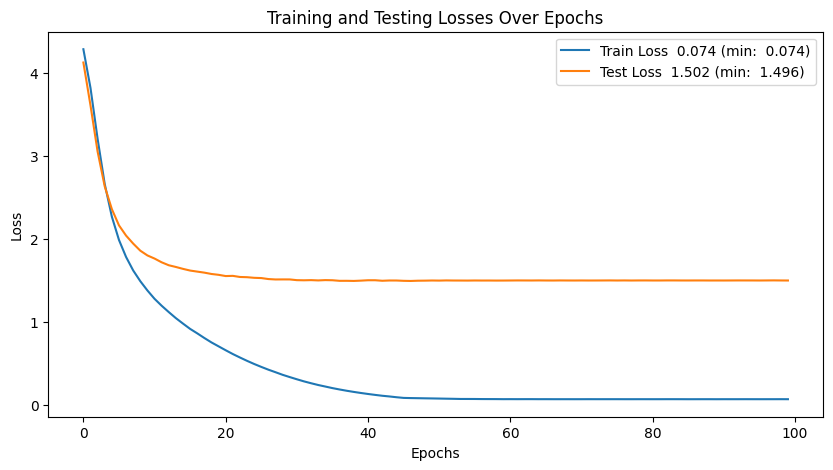

In [138]:
plot_losses(train_losses, val_losses, decimals=3)

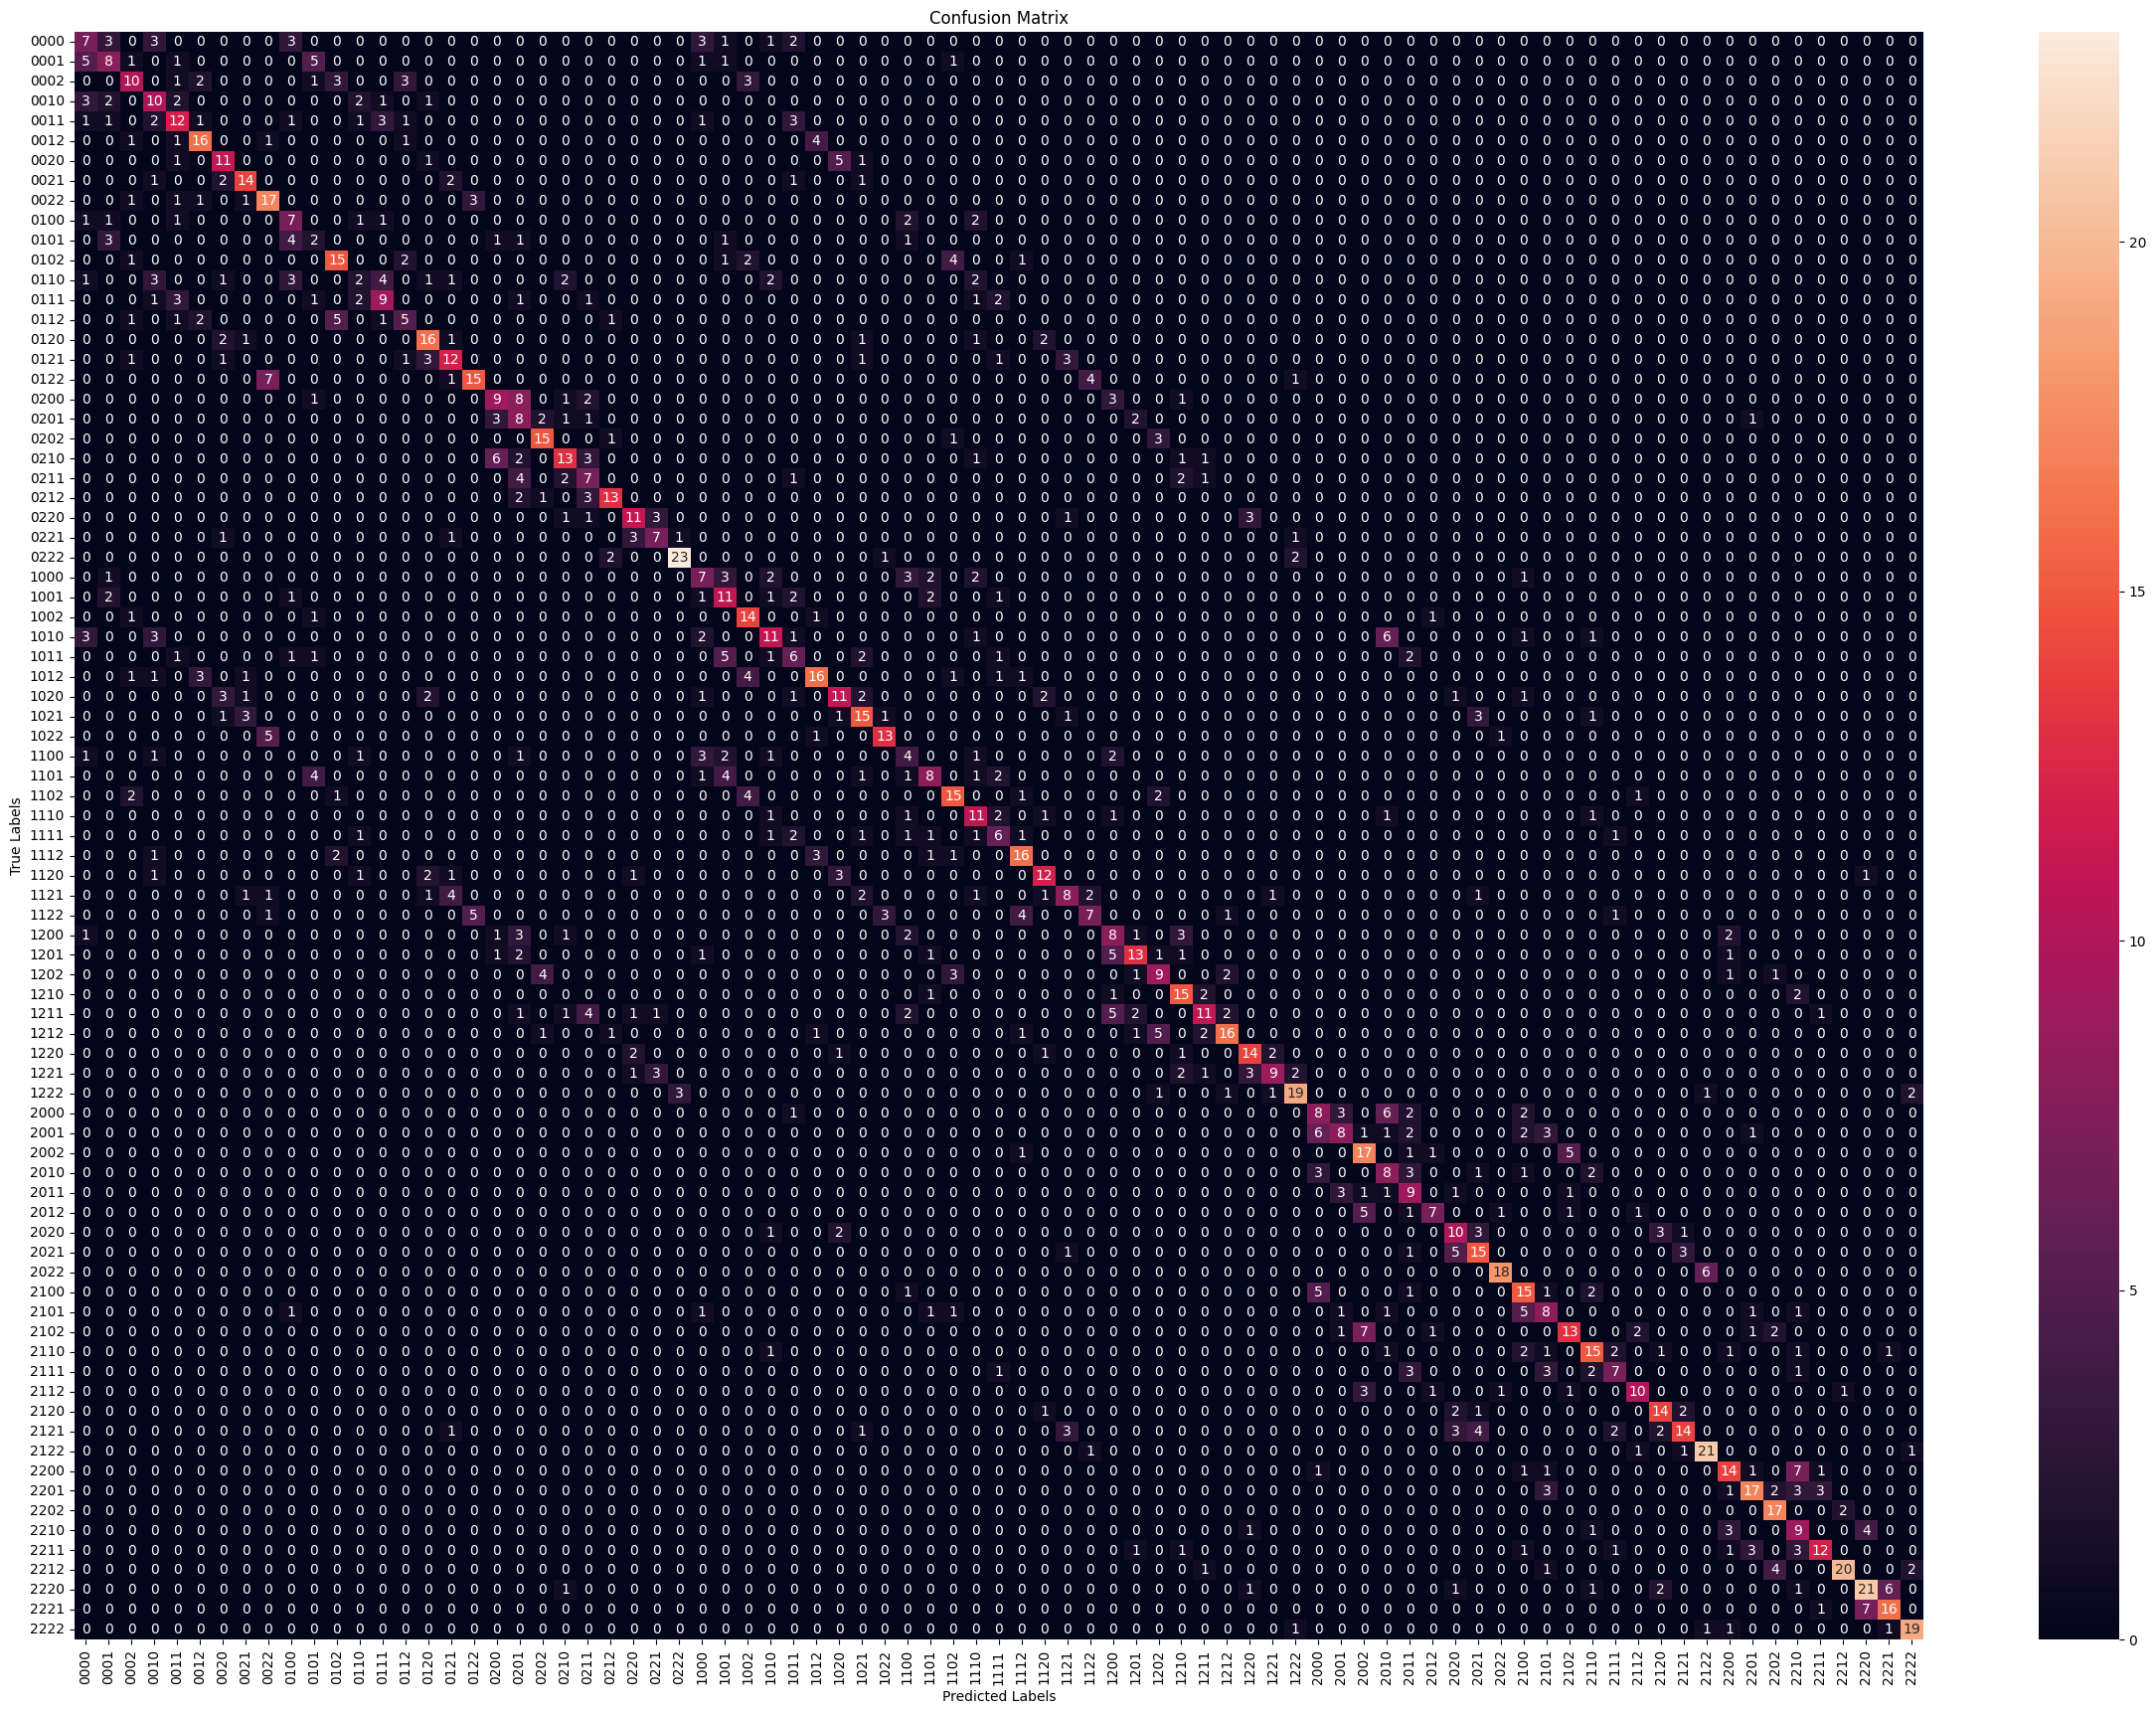

In [139]:
# predictions = model(X_torch.to(device))
# predictions
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(30, 21))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [140]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.5271530444322545


In [141]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 961/1823
Number of correct predictions (val): 983/1822


Creating the least of the weights in 2D as a basis

In [142]:
def build_weights(weights, ls, ps, l1, l2, p1, p2):
    weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
    for l, p, weight in zip(ls, ps, weights):
        weights_ar[l - l1, p - p1] = weight
    return weights_ar

# getting the dimensions
filename = f'../DATA/{folder}/data_{knots[0]}_spectr.csv'
with open(filename, 'r') as file:
    reader = csv.reader(file)
    row = next(iter(reader))
    data_list = json.loads(row[0])
    # Convert the list back to a NumPy array if needed
    # print(data_list)
    # data_array = np.array(data_list)
    data_array = data_list

    l1, l2 = data_array[0], data_array[1]
    p1, p2 = data_array[2], data_array[3]
print(l1, l2, p1, p2)

values_basis = []
for knot in knots:
# for knot in ['6foil']:
    print(knot)
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:

        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        values = build_weights(weights, ls, ps, l1, l2, p1, p2)
        values = values / np.sqrt(np.sum(np.abs(values) ** 2))
        values_basis.append(values)
        # plt.imshow(np.abs(values).T[::-1])
        # plt.colorbar()
        # plt.show()

print(len(values_basis), values_basis[0].shape)

-6 6 0 6
0000


FileNotFoundError: [Errno 2] No such file or directory: '..\\../4foils_L270_0.25_50_64x64x64_v1\\0000.pkl'

In [ ]:
# Function to calculate MSE
def calculate_mse(array1, array2):
    return ((np.abs(array1) - np.abs(array2)) ** 2).mean()

closest_basis_knots = []
true_labels = []
for knot in knots:
    closest_basis_knot = []
    true_label = []
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            true_label.append(knot_types[knot])
            data_array = json.loads(row[0])

            # indx = data_array[4]
            # field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            # plt.imshow(np.abs(field ))
            # plt.show()

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            mse_scores = [calculate_mse(moments, values) for values in values_basis]
            closest_basis_knot.append(np.argmin(mse_scores))
            # plt.imshow(np.abs(moments))
            # plt.colorbar()
            # plt.show()
    true_labels.append(true_label)
    closest_basis_knots.append(closest_basis_knot)

# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:
predicted_labels_spec_np = np.array(closest_basis_knots).reshape(-1)
true_labels_spec_np = np.array(true_labels).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# def build_weights(weights, ls, ps, l1, l2, p1, p2):
#     weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
#     for l, p, weight in zip(ls, ps, weights):
#         weights_ar[l - l1, p - p1] = weight
#     return weights_ar
#
# # getting the dimensions
# filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     row = next(iter(reader))
#     data_list = json.loads(row[0])
#     # Convert the list back to a NumPy array if needed
#     # print(data_list)
#     # data_array = np.array(data_list)
#     data_array = data_list
#
#     l1, l2 = data_array[0], data_array[1]
#     p1, p2 = data_array[2], data_array[3]
# print(l1, l2, p1, p2)

knots_basis = []
knots_basis_dots = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\data_basis\\data_{knot}.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]

            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            knots_basis_dots.append(points_list)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            knots_basis.append(dots_3d)

print(len(knots_basis), knots_basis[0].shape)
print(len(knots_basis_dots), knots_basis_dots[0].shape,knots_basis_dots[0][0])
print(knots_basis_dots[0].shape, knots_basis_dots[3].shape)

In [ ]:
# Function to calculate MSE
def calculate_mse_knot(array1, array2):
    return ((array1 - array2) ** 2).mean()

def calculate_mse_knot_dots(array1, dots):
    # loss = -np.sum([np.array(array1)[np.array(dot)] for dot in dots])
    loss = -np.sum([array1[tuple(dot)] for dot in dots])

    return loss

closest_knots = []
closest_knots_dots = []
true_knots = []
j = -1
for i, x in enumerate(X_torch):
    j += 1
    true_knots.append(torch.argmax(y_torch[i]).item())

    mse_scores = [calculate_mse_knot(x[0], knot_) for knot_ in knots_basis]
    closest_knots.append(np.argmin(mse_scores))

    mse_scores_dots = [calculate_mse_knot_dots(x[0], dots_) for dots_ in knots_basis_dots]
    # print(mse_scores_dots)
    # min_indices = np.where(mse_scores_dots == np.min(mse_scores_dots))[0]
    # if len(min_indices) > 1:
    #     result = 0
    # else:
    #     result = min_indices[0]
    closest_knots_dots.append(np.argmin(mse_scores_dots))
    # plt.imshow(knots_basis[j][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(x[0][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # break


# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:

predicted_labels_spec_np = np.array(closest_knots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

predicted_labels_spec_np = np.array(closest_knots_dots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


X_list_sp = []
Y_list_sp = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:
        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        for row in reader:
                # Deserialize the JSON string back to a list
                data_list = json.loads(row[0])
                # Convert the list back to a NumPy array if needed
                # print(data_list)
                # data_array = np.array(data_list)
                data_array = data_list

                l1, l2 = data_array[0], data_array[1]
                p1, p2 = data_array[2], data_array[3]

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            # print(data_list)
            # data_array = np.array(data_list)
            data_array = data_list

            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]
            indx = data_array[4]
            field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            plt.imshow(np.abs(field ))
            plt.show()

            # print(f'l1, l2, p1, p2: {l1}, {l2}, {p1}, {p2} ({(l2 - l1 + 1) * (p2 - p1 + 1)})')
            # moments = np.array(data_array[4:]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            # plt.imshow(np.abs(moments).T[::-1, :])
            # plt.show()
            values = build_weights(weights, ls, ps, l1, l2, p1, p2)
            print(f"{knot}")
            plt.imshow(np.abs(values))
            plt.colorbar()
            plt.show()
            plt.imshow(np.abs(moments))
            plt.colorbar()
            plt.show()
            # plt.imshow(np.real(moments).T[::-1, :])
            # plt.show()
            print(moments)
            break
            # continue
            # points_list = data_array[2:]
            # Nx, Ny, Nz = data_array[1]
            # if desired_res != (Nx, Ny, Nz):
            #     scale_x = desired_res[0] / Nx
            #     scale_y = desired_res[1] / Ny
            #     scale_z = desired_res[2] / Nz
            #     points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # # Initialize a 3D array with zeros
            # dots_3d = np.zeros(desired_res, dtype=int)
            # # Set the specified coordinates to 1
            # for x, y, z in points_list:
            #     try: dots_3d[x, y, z] = 1
            #     except IndexError: continue
            # X_list.append(dots_3d)
            # # X_list.append(data_array)
            # Y_list.append(knot_types[knot])
    break

In [ ]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)